In [223]:
import pandas as pd
import numpy as np
import single_df_curve
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
input_path = '/Users/susynishida/Desktop/dev/Python/Finance/input/20180731'
file_name = 'TenorBasis.csv'
file_path = os.path.join(input_path, file_name)

In [37]:
df_tb = pd.read_csv(file_path)
df_tb.head()

,date,item,ccy,tenor,maturity,spread
0,2018/7/31,TenorBasis,JPY,3M,1Y,-0.008
1,2018/7/31,TenorBasis,JPY,3M,2Y,-0.009
2,2018/7/31,TenorBasis,JPY,3M,3Y,-0.010
3,2018/7/31,TenorBasis,JPY,3M,4Y,-0.010
4,2018/7/31,TenorBasis,JPY,3M,5Y,-0.010


In [220]:
class TenorBasis():
    def __init__(self, df, str_ccy):
        self._df = df[df['ccy'] == str_ccy]
        self._ccy = str_ccy
        self._str_tenor = (self._df['tenor'].unique())[0]
        self._int_tenor_m = int((self._str_tenor)[:-1])
        self._float_tenor_y = (self._int_tenor_m) / 12
        self._int_max_mat = int((self._df.iloc[-1]['maturity'])[:-1])
        
    def add_col_mat_interp(self):
        df_add_col = (self._df).copy()
        df_add_col['flo_mat_for_intep'] = df_add_col['maturity'].apply(lambda x: float(x[:-1]))
        return df_add_col
        
    def gen_maturity(self):
        maturity_list = np.arange(0, self._int_max_mat + self._float_tenor_y, self._float_tenor_y)
        return maturity_list
    
    def gen_df_for_interp(self):
        df_maturity = pd.DataFrame(self.gen_maturity(), columns=['maturity_for_interp'])
        df_add_col = self.add_col_mat_interp()
        df_for_intep = pd.merge(df_maturity, df_add_col, left_on='maturity_for_interp', right_on='flo_mat_for_intep', how='outer')
        return df_for_intep
    
    def interp_spread(self):
        df_for_intep = self.gen_df_for_interp()
        df_for_intep.iloc[0] = 0
        df_interp = (df_for_intep.set_index('maturity_for_interp')[['spread']]).interpolate('index')
        return df_interp
    
    def get_test(self):
        return self.interp_spread()

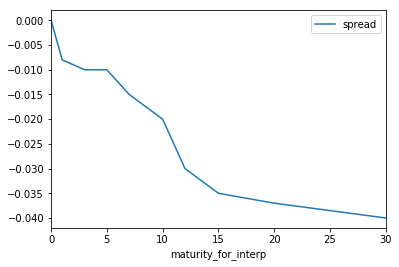

In [224]:
tb = TenorBasis(df_tb, 'JPY')
tb.interp_spread().plot()

In [215]:
tb = TenorBasis(df_tb, 'JPY')
tb.get_test()

,maturity_for_interp,date,item,ccy,tenor,maturity,spread,flo_mat_for_intep
0,0.00,0,0,0,0,0,0.000,0.0
1,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.00,2018/7/31,TenorBasis,JPY,3M,1Y,-0.008,1.0


In [194]:
tb = TenorBasis(df_tb, 'JPY')
tb.gen_df_for_interp().set_index('maturity_for_interp')[['spread']].interpolate('index', limit_direction='both')

,spread
maturity_for_interp,
0.00,-0.008000
0.25,-0.008000
0.50,-0.008000
0.75,-0.008000
1.00,-0.008000
1.25,-0.008250
1.50,-0.008500
1.75,-0.008750
2.00,-0.009000
